In [2]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
import sys

from google.colab import drive
drive.mount("/content/drive")

main_path = '/content/drive/My Drive/Workspace/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
class ConfigLorenz:
    T = 10.0
    T_unit = 0.01
    N = int(T / T_unit)
    X_start = 6.0
    Y_start = 6.0
    Z_start = 15.0
    rho = 14.0
    sigma = 10.0
    beta = 8.0 / 3.0
    ub = T
    lb = 0.0


class SimpleNetworkLorenz(nn.Module):
    def __init__(self, config):
        super(SimpleNetworkLorenz, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkLorenz"
        self.sig = nn.Tanh()

        # Design A
        # self.fc1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 100),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(100, 100),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(100, 100),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(100, 1),
        #     # 'sig4': nn.ReLU()
        # }))

        # self.fc2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 100),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(100, 100),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(100, 100),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(100, 1),
        #     # 'sig4': nn.ReLU()
        # }))

        # self.fc3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 100),
        #     'sig1': self.sig,
        #     'lin2': nn.Linear(100, 100),
        #     'sig2': self.sig,
        #     'lin3': nn.Linear(100, 100),
        #     'sig3': self.sig,
        #     'lin4': nn.Linear(100, 1),
        #     # 'sig4': nn.ReLU()
        # }))

        # Design D
        self.fc_x1_0_1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
        }))

        self.fc_x2_0_1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
        }))

        self.fc_x3_0_1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
        }))

        self.fc_x1_1_2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(200, 100),
            'sig1': self.sig,
        }))

        self.fc_x2_1_2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(300, 100),
            'sig1': self.sig,
        }))

        self.fc_x3_1_2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(300, 100),
            'sig1': self.sig,
        }))

        self.fc_x1_2_3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(200, 100),
            'sig1': self.sig,
        }))

        self.fc_x2_2_3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(300, 100),
            'sig1': self.sig,
        }))

        self.fc_x3_2_3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(300, 100),
            'sig1': self.sig,
        }))

        self.fc_x1_3_4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(100, 1),
        }))

        self.fc_x2_3_4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(100, 1),
        }))

        self.fc_x3_3_4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(100, 1),
        }))

    def forward(self, inputs):
        x1, x2, x3 = torch.chunk(inputs, 3, 1)
        # Design A
        # x1_new = self.fc1(x1)
        # x2_new = self.fc2(x2)
        # x3_new = self.fc3(x3)

        # Design D
        x1_1_output = self.fc_x1_0_1(x1)
        x2_1_output = self.fc_x2_0_1(x2)
        x3_1_output = self.fc_x3_0_1(x3)

        x1_2_input = torch.cat((x1_1_output, x2_1_output), 1)
        x2_2_input = torch.cat((x1_1_output, x2_1_output, x3_1_output), 1)
        x3_2_input = torch.cat((x1_1_output, x2_1_output, x3_1_output), 1)

        x1_2_output = self.fc_x1_1_2(x1_2_input)
        x2_2_output = self.fc_x2_1_2(x2_2_input)
        x3_2_output = self.fc_x3_1_2(x3_2_input)

        x1_3_input = torch.cat((x1_2_output, x2_2_output), 1)
        x2_3_input = torch.cat((x1_2_output, x2_2_output, x3_2_output), 1)
        x3_3_input = torch.cat((x1_2_output, x2_2_output, x3_2_output), 1)

        x1_3_output = self.fc_x1_2_3(x1_3_input)
        x2_3_output = self.fc_x2_2_3(x2_3_input)
        x3_3_output = self.fc_x3_2_3(x3_3_input)

        x1_new = self.fc_x1_3_4(x1_3_output)
        x2_new = self.fc_x2_3_4(x2_3_output)
        x3_new = self.fc_x3_3_4(x3_3_output)

        outputs = torch.cat((x1_new, x2_new, x3_new), 1)
        return outputs

    def generate_x(self):
        x = [[i*self.config.T_unit, i*self.config.T_unit, i*self.config.T_unit] for i in range(self.config.N)]  # toy
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0, -1.0, -1.0]).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(np.asarray([self.config.X_start, self.config.Y_start, self.config.Z_start]).reshape([1, -1])).float().to(self.device)
        self.yend = torch.Tensor(np.asarray([0, 0, 100]).reshape([1, -1])).float().to(self.device)
        self.tend = torch.Tensor(np.asarray([1.0, 1.0, 1.0]).reshape([1, -1])).float().to(self.device)

    def loss(self):
        self.eval()
        y = self.forward(self.x)
        xx = y[:, 0:1]
        yy = y[:, 1:2]
        zz = y[:, 2:3]

        xx_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
        yy_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]
        zz_t = torch.gradient(y[:, 2:3].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 2:3].reshape([self.config.N]),))[0]

        xx_t = xx_t.reshape([self.config.N, 1])
        yy_t = yy_t.reshape([self.config.N, 1])
        yy_t = yy_t.reshape([self.config.N, 1])
        # print(y_t,u_t)
        f_xx = xx_t - (self.config.sigma * (yy - xx))
        f_yy = yy_t - (xx * (self.config.rho - zz) - yy)
        f_zz = zz_t - (xx * yy - self.config.beta * zz)

        # f_s = s_t - (- self.config.beta * s * i)
        # f_i = i_t - (self.config.beta * s * i - self.config.gamma * i)
        # f_r = r_t - (self.config.gamma * i)


        f_y = torch.cat((f_xx, f_yy, f_zz), 1)
        y0_pred = self.forward(self.t0)
        # yend_pred = self.forward(self.tend)
        # print_flag = False  # True # False
        # if print_flag:
        #     print("u=", u.shape, u, "v=", v.shape, v, "t=", (self.decode_t(self.x)[:, 0:1]).shape, self.decode_t(self.x)[:, 0:1])
        #     print("u_t=", u_t, "shape=", u_t.shape, "u_t_minus=", (self.config.alpha - self.config.gamma * v) * u,
        #           "shape=", ((self.config.alpha - self.config.gamma * v) * u).shape)
        #     print("v_t=", v_t, "shape=", v_t.shape, "v_t_minus=",
        #           (-self.config.beta + self.config.e * self.config.gamma * u) * v, "shape=",
        #           ((-self.config.beta + self.config.e * self.config.gamma * u) * v).shape)
        #     print("self.t0 =", self.t0, "self.t0=", self.t0, "self.y0 =", self.y0,
        #           "y0_pred =", y0_pred, "self.y0 - y0_pred =", self.y0 - y0_pred)

        # loss_2_weights = [[i, i] for i in range(20000)]  # toy
        # loss_2_weights = np.asarray(loss_2_weights)
        # loss_2_weights = torch.Tensor(loss_2_weights).float().to(self.device)

        loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        loss_2 = torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
        loss_3 = torch.mean(torch.square(0.01/(xx*xx+yy*yy+zz*zz+1e-8)))
        # loss_3 = torch.mean(torch.square((torch.abs(xx) - xx))) + torch.mean(torch.square((torch.abs(yy) - yy))) + torch.mean(torch.square((torch.abs(zz) - zz))) #+ torch.mean(torch.square((0.1/(s * s)))) + torch.mean(torch.square((0.1/(i * i)))) + torch.mean(torch.square((0.1/(r * r))))
        # loss_4 = torch.mean(torch.square(1.0/((s+1e-6)*(s+1e-6)+1e-6))) + torch.mean(torch.square(1.0/((i+1e-6)*(i+1e-6)+1e-6))) + torch.mean(torch.square(1.0/((r+1e-6)*(r+1e-6)+1e-6)))
        
        # loss_3 = torch.mean(torch.square(1/(u*u+v*v)))
        # loss_3 = torch.mean(torch.square(1.0 / u - (self.config.e * self.config.gamma / self.config.beta))) + \
        #     torch.mean(torch.square(1.0 / v - (self.config.gamma / self.config.alpha)))
        # loss_3 = 10 * (torch.abs(torch.sum(y0_pred) - self.config.SIR_sum) + torch.abs(torch.sum(yend_pred) - self.config.SIR_sum))
        loss = loss_1 + loss_2 + loss_3
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])
        self.train()
        return loss, [loss_1, loss_2, loss_3]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [5]:
def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def train_lorenz(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.rho}_{config.sigma}_{config.beta}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.rho}_{config.sigma}_{config.beta}_{now_string}_best.pt"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1))
    scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=1000)
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        loss, loss_list = model.loss()
        loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        optimizer.step()
        scheduler.step()
        best_loss = 999999
        if epoch % epoch_step == 0:
            now_time = time.time()
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_lorenz(model, args, config, now_string, True)

def test_lorenz(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.rho}_{config.sigma}_{config.beta}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    # print("t=", t)
    # print("t0=", model.t0)
    # print("y=", y)
    # print("y0_pred=", y0_pred)
    xx, yy, zz = torch.chunk(y, 3, 1)
    # print("u=", u)
    # print("v=", v)
    xx = [item[0] for item in xx.cpu().detach().numpy()]
    yy = [item[0] for item in yy.cpu().detach().numpy()]
    zz = [item[0] for item in zz.cpu().detach().numpy()]
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
    pairs = [[xxx, yyy, zzz, x_iter] for xxx, yyy, zzz, x_iter in zip(xx, yy, zz, x)]
    pairs.sort(key=lambda xxxx: xxxx[-1])
    xx = [item[0] for item in pairs]
    yy = [item[1] for item in pairs]
    zz = [item[2] for item in pairs]
    x = [item[3] for item in pairs]
    print("x=", xx[:10], "...", xx[-10:])
    print("y=", yy[:10], "...", yy[-10:])
    print("z=", zz[:10], "...", zz[-10:])
    print("t=", x[:10], "...", x[-10:])
    plt.plot(x, xx, marker='.', markersize=0.2, linewidth=0.1, c="b")
    plt.plot(x, yy, marker='.', markersize=0.2, linewidth=0.1, c="r")
    plt.plot(x, zz, marker='.', markersize=0.2, linewidth=0.1, c="g")
    figure_save_path_2D = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.rho}_{config.sigma}_{config.beta}_{now_string}_{int(time.time())}_2D.png"
    figure_save_path_3D = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.rho}_{config.sigma}_{config.beta}_{now_string}_{int(time.time())}_3D.png"
    plt.savefig(figure_save_path_2D, dpi=300)
    if show_flag:
        plt.show()
    plt.clf()

    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.plot(xx, yy, zz)
    plt.draw()
    plt.savefig(figure_save_path_3D, dpi=300)
    if show_flag:
        plt.show()
    plt.clf()
    print("Saved as {}".format(figure_save_path_2D))
    print("Saved as {}".format(figure_save_path_3D))

class Args:
  epoch = 100000
  epoch_step = 1000
  lr = 0.001
  main_path = "."
  save_step = 10000

def draw_loss(loss_list):
    map = np.asarray([[loss] for loss in loss_list])
    plt.plot(map)
    plt.show()
    plt.clf()

def run_lorenz(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=100, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigLorenz
    model = SimpleNetworkLorenz(config).to(device)
    train_lorenz(model, args, config, now_string)
    model = SimpleNetworkLorenz(config).to(device)
    test_lorenz(model, args, config, now_string)

using cuda
epoch = 100000
epoch_step = 1000
model_name = SimpleNetworkLorenz
now_string = 2022-04-21-22-32-06
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_best.pt
Epoch [01000/100000] Loss:2.220170 Loss_1:0.098812 Loss_2:2.121358 Loss_3:0.000000 Lr:0.009990 Time:8.761489s (0.15min in total)
Epoch [02000/100000] Loss:0.074835 Loss_1:0.040259 Loss_2:0.034577 Loss_3:0.000000 Lr:0.000110 Time:8.784394s (0.29min in total)
Epoch [03000/100000] Loss:0.223358 Loss_1:0.037786 Loss_2:0.185573 Loss_3:0.000000 Lr:0.009990 Time:8.837784s (0.44min in total)
Epoch [04000/100000] Loss:0.062843 Loss_1:0.023905 Loss_2:0.038938 Loss_3:0.000000 Lr:0.000110 Time:8.994308s (0.59min in total)
Epoch [05000/100000] Loss:0.100079 Loss_1:0.0421

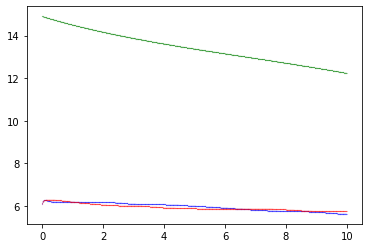

<Figure size 432x288 with 0 Axes>

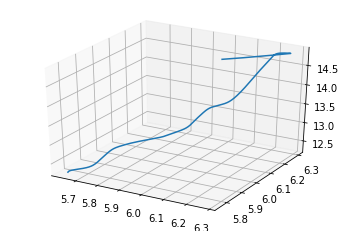

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580423_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580423_3D.png
Epoch [11000/100000] Loss:2.885837 Loss_1:0.007960 Loss_2:2.877877 Loss_3:0.000000 Lr:0.009990 Time:9.544320s (1.62min in total)
Epoch [12000/100000] Loss:0.062992 Loss_1:0.026299 Loss_2:0.036692 Loss_3:0.000000 Lr:0.000110 Time:8.588279s (1.76min in total)
Epoch [13000/100000] Loss:3.193973 Loss_1:0.011706 Loss_2:3.182267 Loss_3:0.000000 Lr:0.009990 Time:8.585190s (1.91min in total)
Epoch [14000/100000] Loss:0.077064 Loss_1:0.041925 Loss_2:0.035139 Loss_3:0.000000 Lr:0.000110 Time:8.594963s (2.05min in total)
Epoch [15000/100000] Loss:0.098239 Loss_1:0.046070 Loss_2:0.052169 Loss_3:0.000000 Lr:0.009990 Time:8.660878s (2.19min in total)
Epoch [16000/100000] Loss:0.081979 

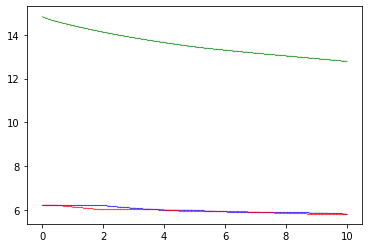

<Figure size 432x288 with 0 Axes>

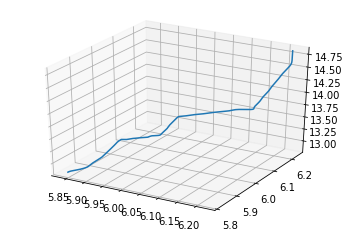

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580510_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580510_3D.png
Epoch [21000/100000] Loss:1.510220 Loss_1:0.094708 Loss_2:1.415512 Loss_3:0.000000 Lr:0.009990 Time:9.539575s (3.07min in total)
Epoch [22000/100000] Loss:0.076085 Loss_1:0.041364 Loss_2:0.034721 Loss_3:0.000000 Lr:0.000110 Time:8.592842s (3.22min in total)
Epoch [23000/100000] Loss:2.659211 Loss_1:0.169637 Loss_2:2.489574 Loss_3:0.000000 Lr:0.009990 Time:8.682846s (3.36min in total)
Epoch [24000/100000] Loss:0.077173 Loss_1:0.041498 Loss_2:0.035676 Loss_3:0.000000 Lr:0.000110 Time:8.800283s (3.51min in total)
Epoch [25000/100000] Loss:0.141127 Loss_1:0.047350 Loss_2:0.093777 Loss_3:0.000000 Lr:0.009990 Time:8.601605s (3.65min in total)
Epoch [26000/100000] Loss:0.077817 

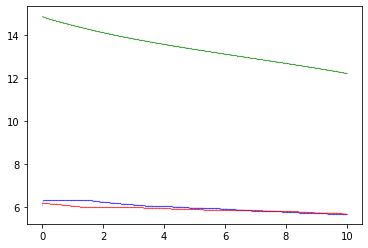

<Figure size 432x288 with 0 Axes>

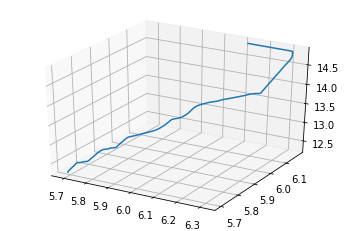

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580598_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580598_3D.png
Epoch [31000/100000] Loss:1.625605 Loss_1:0.110674 Loss_2:1.514932 Loss_3:0.000000 Lr:0.009990 Time:9.601096s (4.53min in total)
Epoch [32000/100000] Loss:0.075248 Loss_1:0.040478 Loss_2:0.034770 Loss_3:0.000000 Lr:0.000110 Time:8.582644s (4.67min in total)
Epoch [33000/100000] Loss:0.142974 Loss_1:0.038645 Loss_2:0.104329 Loss_3:0.000000 Lr:0.009990 Time:8.667516s (4.82min in total)
Epoch [34000/100000] Loss:0.074771 Loss_1:0.040351 Loss_2:0.034420 Loss_3:0.000000 Lr:0.000110 Time:8.643825s (4.96min in total)
Epoch [35000/100000] Loss:2.696954 Loss_1:0.016344 Loss_2:2.680610 Loss_3:0.000000 Lr:0.009990 Time:8.622668s (5.10min in total)
Epoch [36000/100000] Loss:0.074943 

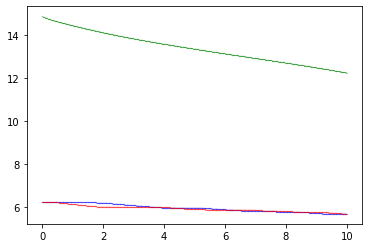

<Figure size 432x288 with 0 Axes>

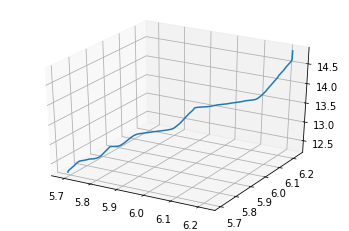

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580685_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580685_3D.png
Epoch [41000/100000] Loss:0.180519 Loss_1:0.039249 Loss_2:0.141270 Loss_3:0.000000 Lr:0.009990 Time:9.713369s (5.99min in total)
Epoch [42000/100000] Loss:0.075578 Loss_1:0.041206 Loss_2:0.034371 Loss_3:0.000000 Lr:0.000110 Time:8.678305s (6.13min in total)
Epoch [43000/100000] Loss:0.759901 Loss_1:0.059851 Loss_2:0.700050 Loss_3:0.000000 Lr:0.009990 Time:8.693732s (6.27min in total)
Epoch [44000/100000] Loss:0.075845 Loss_1:0.041111 Loss_2:0.034734 Loss_3:0.000000 Lr:0.000110 Time:8.777372s (6.42min in total)
Epoch [45000/100000] Loss:1.033080 Loss_1:0.020222 Loss_2:1.012858 Loss_3:0.000000 Lr:0.009990 Time:8.752364s (6.57min in total)
Epoch [46000/100000] Loss:0.075944 

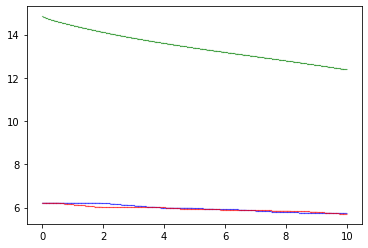

<Figure size 432x288 with 0 Axes>

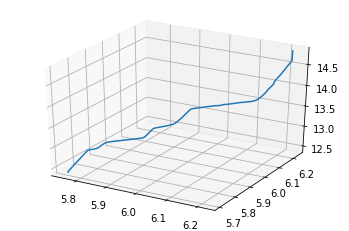

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580773_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580773_3D.png
Epoch [51000/100000] Loss:0.169692 Loss_1:0.052988 Loss_2:0.116704 Loss_3:0.000000 Lr:0.009990 Time:9.601007s (7.45min in total)
Epoch [52000/100000] Loss:0.076264 Loss_1:0.041386 Loss_2:0.034878 Loss_3:0.000000 Lr:0.000110 Time:8.699779s (7.59min in total)
Epoch [53000/100000] Loss:0.354922 Loss_1:0.030149 Loss_2:0.324773 Loss_3:0.000000 Lr:0.009990 Time:8.589572s (7.74min in total)
Epoch [54000/100000] Loss:0.075756 Loss_1:0.041186 Loss_2:0.034571 Loss_3:0.000000 Lr:0.000110 Time:8.635994s (7.88min in total)
Epoch [55000/100000] Loss:0.164235 Loss_1:0.053440 Loss_2:0.110795 Loss_3:0.000000 Lr:0.009990 Time:8.639321s (8.02min in total)
Epoch [56000/100000] Loss:0.075628 

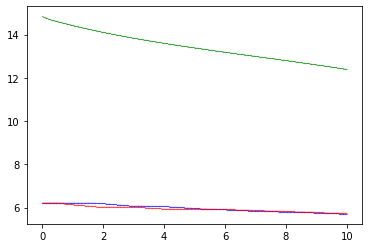

<Figure size 432x288 with 0 Axes>

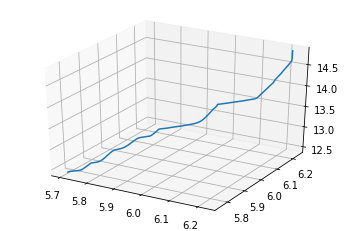

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580860_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580860_3D.png
Epoch [61000/100000] Loss:0.277783 Loss_1:0.059609 Loss_2:0.218174 Loss_3:0.000000 Lr:0.009990 Time:9.711635s (8.91min in total)
Epoch [62000/100000] Loss:0.075549 Loss_1:0.041196 Loss_2:0.034353 Loss_3:0.000000 Lr:0.000110 Time:8.700215s (9.05min in total)
Epoch [63000/100000] Loss:0.292430 Loss_1:0.031941 Loss_2:0.260490 Loss_3:0.000000 Lr:0.009990 Time:8.708950s (9.20min in total)
Epoch [64000/100000] Loss:0.076022 Loss_1:0.041416 Loss_2:0.034606 Loss_3:0.000000 Lr:0.000110 Time:8.712278s (9.34min in total)
Epoch [65000/100000] Loss:0.185702 Loss_1:0.095169 Loss_2:0.090533 Loss_3:0.000000 Lr:0.009990 Time:8.634980s (9.49min in total)
Epoch [66000/100000] Loss:0.079672 

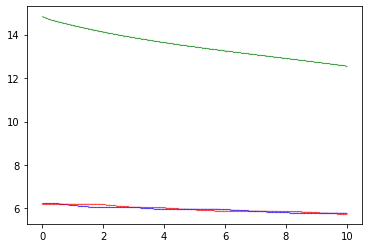

<Figure size 432x288 with 0 Axes>

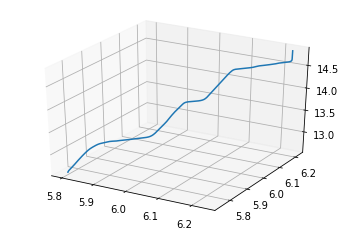

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580948_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650580948_3D.png
Epoch [71000/100000] Loss:0.104133 Loss_1:0.042819 Loss_2:0.061315 Loss_3:0.000000 Lr:0.009990 Time:9.688626s (10.37min in total)
Epoch [72000/100000] Loss:0.078309 Loss_1:0.042158 Loss_2:0.036151 Loss_3:0.000000 Lr:0.000110 Time:8.615377s (10.51min in total)
Epoch [73000/100000] Loss:0.508851 Loss_1:0.080588 Loss_2:0.428262 Loss_3:0.000000 Lr:0.009990 Time:8.635491s (10.66min in total)
Epoch [74000/100000] Loss:0.079061 Loss_1:0.042287 Loss_2:0.036774 Loss_3:0.000000 Lr:0.000110 Time:8.622676s (10.80min in total)
Epoch [75000/100000] Loss:0.195354 Loss_1:0.025844 Loss_2:0.169510 Loss_3:0.000000 Lr:0.009990 Time:8.668368s (10.94min in total)
Epoch [76000/100000] Loss:0.07

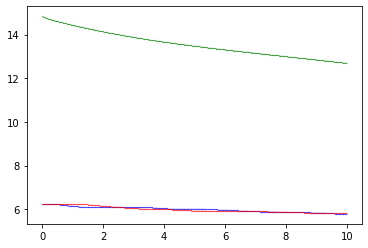

<Figure size 432x288 with 0 Axes>

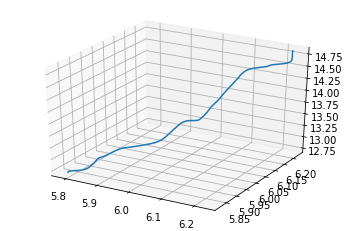

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650581036_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650581036_3D.png
Epoch [81000/100000] Loss:0.450872 Loss_1:0.028239 Loss_2:0.422632 Loss_3:0.000000 Lr:0.009990 Time:9.703857s (11.84min in total)
Epoch [82000/100000] Loss:0.078656 Loss_1:0.042295 Loss_2:0.036362 Loss_3:0.000000 Lr:0.000110 Time:8.615438s (11.98min in total)
Epoch [83000/100000] Loss:2.102489 Loss_1:0.022725 Loss_2:2.079764 Loss_3:0.000000 Lr:0.009990 Time:8.641020s (12.12min in total)
Epoch [84000/100000] Loss:0.077866 Loss_1:0.042434 Loss_2:0.035433 Loss_3:0.000000 Lr:0.000110 Time:8.736225s (12.27min in total)
Epoch [85000/100000] Loss:0.829315 Loss_1:0.024693 Loss_2:0.804622 Loss_3:0.000000 Lr:0.009990 Time:8.709254s (12.41min in total)
Epoch [86000/100000] Loss:0.07

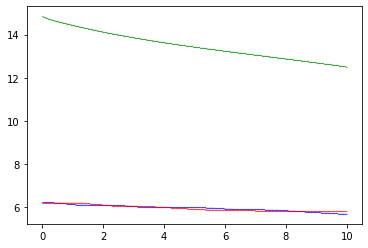

<Figure size 432x288 with 0 Axes>

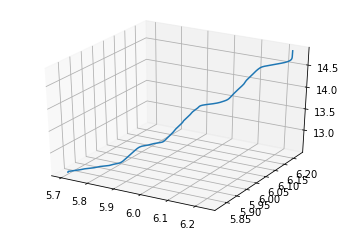

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650581123_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650581123_3D.png
Epoch [91000/100000] Loss:0.333913 Loss_1:0.032555 Loss_2:0.301358 Loss_3:0.000000 Lr:0.009990 Time:9.625698s (13.29min in total)
Epoch [92000/100000] Loss:0.077743 Loss_1:0.042396 Loss_2:0.035347 Loss_3:0.000000 Lr:0.000110 Time:8.703166s (13.44min in total)
Epoch [93000/100000] Loss:0.161681 Loss_1:0.050884 Loss_2:0.110797 Loss_3:0.000000 Lr:0.009990 Time:8.556010s (13.58min in total)
Epoch [94000/100000] Loss:0.078461 Loss_1:0.042706 Loss_2:0.035756 Loss_3:0.000000 Lr:0.000110 Time:8.712462s (13.73min in total)
Epoch [95000/100000] Loss:0.964334 Loss_1:0.021711 Loss_2:0.942623 Loss_3:0.000000 Lr:0.009990 Time:8.720303s (13.87min in total)
Epoch [96000/100000] Loss:0.07

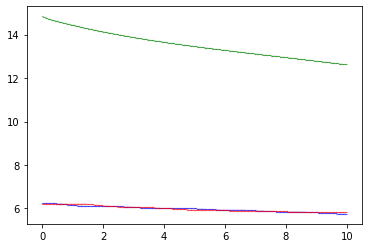

<Figure size 432x288 with 0 Axes>

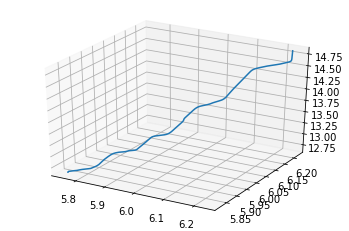

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650581211_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650581211_3D.png
Testing & drawing...
x= [6.2328906, 6.232862, 6.2328305, 6.2327967, 6.23276, 6.2327213, 6.2326803, 6.232638, 6.232594, 6.232549] ... [5.7514844, 5.7511377, 5.750828, 5.750566, 5.750359, 5.750208, 5.7501082, 5.7500496, 5.7500215, 5.75001]
y= [6.219888, 6.219888, 6.219888, 6.219888, 6.219888, 6.219888, 6.219888, 6.219888, 6.219888, 6.219888] ... [5.822785, 5.822785, 5.822785, 5.822785, 5.822785, 5.822785, 5.822785, 5.822785, 5.822785, 5.822785]
z= [14.842464, 14.837338, 14.831893, 14.826165, 14.820203, 14.814058, 14.807793, 14.801463, 14.795126, 14.788833] ... [12.6389475, 12.637233, 12.635478, 12.633665, 12.631789, 12.629868, 12.627957, 12.626159, 12.624607, 12.623418]
t= 

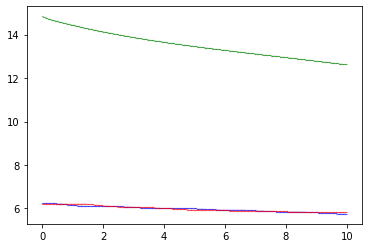

<Figure size 432x288 with 0 Axes>

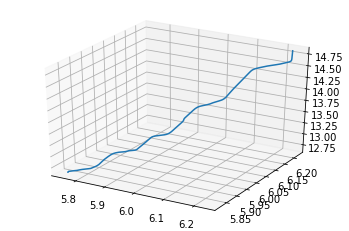

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650581212_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_100000_1000_0.001_14.0_10.0_2.6666666666666665_2022-04-21-22-32-06_1650581212_3D.png


<Figure size 432x288 with 0 Axes>

In [6]:
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_lorenz(main_path)

using cuda
epoch = 1000
epoch_step = 10
model_name = SimpleNetworkLorenz
now_string = 2022-04-11-05-08-25
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_loss_1000.npy
Epoch [00010/01000] Loss:11.948335 Loss_1:10.448142 Loss_2:1.500192 Loss_3:0.000001 Lr:0.000990 Time:18.116364s (0.30min in total)
Epoch [00020/01000] Loss:0.177185 Loss_1:0.050585 Loss_2:0.126600 Loss_3:0.000000 Lr:0.000980 Time:19.273191s (0.62min in total)
Epoch [00030/01000] Loss:0.085503 Loss_1:0.051929 Loss_2:0.033573 Loss_3:0.000000 Lr:0.000971 Time:18.501175s (0.93min in total)
Epoch [00040/01000] Loss:0.06

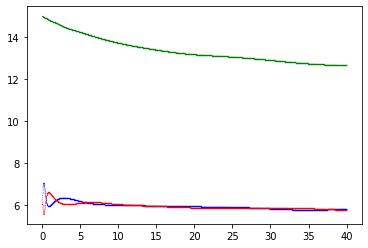

<Figure size 432x288 with 0 Axes>

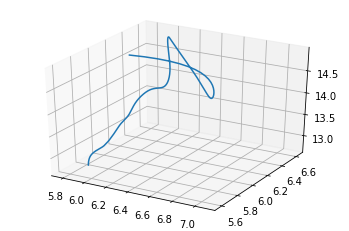

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649653896_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649653896_3D.png


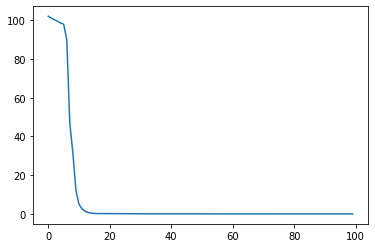

Epoch [00110/01000] Loss:0.014236 Loss_1:0.000969 Loss_2:0.013267 Loss_3:0.000000 Lr:0.000901 Time:19.668859s (3.45min in total)
Epoch [00120/01000] Loss:0.013776 Loss_1:0.000847 Loss_2:0.012929 Loss_3:0.000000 Lr:0.000893 Time:18.628632s (3.76min in total)
Epoch [00130/01000] Loss:0.013418 Loss_1:0.000760 Loss_2:0.012658 Loss_3:0.000000 Lr:0.000885 Time:18.631012s (4.07min in total)
Epoch [00140/01000] Loss:0.013127 Loss_1:0.000686 Loss_2:0.012441 Loss_3:0.000000 Lr:0.000877 Time:18.673686s (4.39min in total)
Epoch [00150/01000] Loss:0.012921 Loss_1:0.000638 Loss_2:0.012283 Loss_3:0.000000 Lr:0.000870 Time:18.650410s (4.70min in total)
Epoch [00160/01000] Loss:0.012835 Loss_1:0.000643 Loss_2:0.012191 Loss_3:0.000000 Lr:0.000862 Time:14.854160s (4.94min in total)
Epoch [00170/01000] Loss:0.012822 Loss_1:0.000678 Loss_2:0.012144 Loss_3:0.000000 Lr:0.000855 Time:12.897218s (5.16min in total)
Epoch [00180/01000] Loss:0.012818 Loss_1:0.000664 Loss_2:0.012154 Loss_3:0.000000 Lr:0.000847 Tim

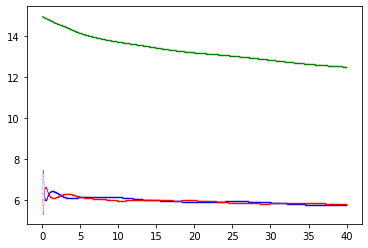

<Figure size 432x288 with 0 Axes>

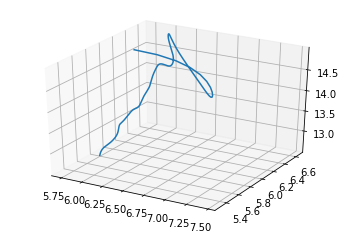

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654047_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654047_3D.png


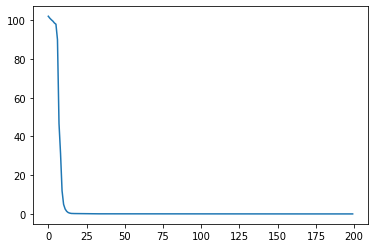

Epoch [00210/01000] Loss:0.012810 Loss_1:0.000629 Loss_2:0.012181 Loss_3:0.000000 Lr:0.000826 Time:10.117147s (5.81min in total)
Epoch [00220/01000] Loss:0.012810 Loss_1:0.000624 Loss_2:0.012186 Loss_3:0.000000 Lr:0.000820 Time:5.290976s (5.90min in total)
Epoch [00230/01000] Loss:0.012813 Loss_1:0.000612 Loss_2:0.012201 Loss_3:0.000000 Lr:0.000813 Time:9.625412s (6.06min in total)
Epoch [00240/01000] Loss:0.012818 Loss_1:0.000601 Loss_2:0.012216 Loss_3:0.000000 Lr:0.000806 Time:11.577913s (6.25min in total)
Epoch [00250/01000] Loss:0.012828 Loss_1:0.000589 Loss_2:0.012239 Loss_3:0.000000 Lr:0.000800 Time:13.957165s (6.49min in total)
Epoch [00260/01000] Loss:0.012837 Loss_1:0.000581 Loss_2:0.012256 Loss_3:0.000000 Lr:0.000794 Time:12.492624s (6.69min in total)
Epoch [00270/01000] Loss:0.012849 Loss_1:0.000572 Loss_2:0.012277 Loss_3:0.000000 Lr:0.000787 Time:11.832237s (6.89min in total)
Epoch [00280/01000] Loss:0.012859 Loss_1:0.000567 Loss_2:0.012291 Loss_3:0.000000 Lr:0.000781 Time:

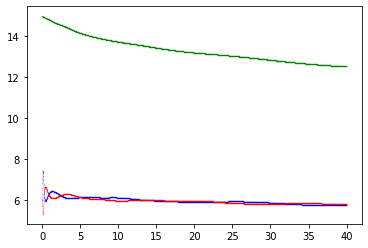

<Figure size 432x288 with 0 Axes>

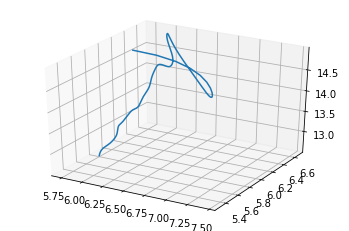

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654153_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654153_3D.png


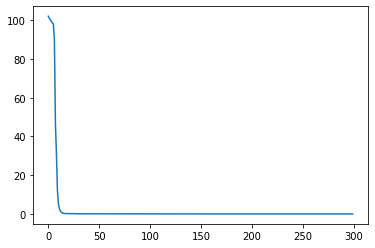

Epoch [00310/01000] Loss:0.012908 Loss_1:0.000549 Loss_2:0.012359 Loss_3:0.000000 Lr:0.000763 Time:13.643569s (7.65min in total)
Epoch [00320/01000] Loss:0.012925 Loss_1:0.000542 Loss_2:0.012383 Loss_3:0.000000 Lr:0.000758 Time:11.976006s (7.84min in total)
Epoch [00330/01000] Loss:0.012929 Loss_1:0.000543 Loss_2:0.012386 Loss_3:0.000000 Lr:0.000752 Time:15.179283s (8.10min in total)
Epoch [00340/01000] Loss:0.012927 Loss_1:0.000543 Loss_2:0.012384 Loss_3:0.000000 Lr:0.000746 Time:10.363773s (8.27min in total)
Epoch [00350/01000] Loss:0.012925 Loss_1:0.000544 Loss_2:0.012382 Loss_3:0.000000 Lr:0.000741 Time:10.026657s (8.44min in total)
Epoch [00360/01000] Loss:0.012924 Loss_1:0.000544 Loss_2:0.012380 Loss_3:0.000000 Lr:0.000735 Time:8.063639s (8.57min in total)
Epoch [00370/01000] Loss:0.012924 Loss_1:0.000545 Loss_2:0.012379 Loss_3:0.000000 Lr:0.000730 Time:7.472471s (8.70min in total)
Epoch [00380/01000] Loss:0.012923 Loss_1:0.000546 Loss_2:0.012377 Loss_3:0.000000 Lr:0.000725 Time:

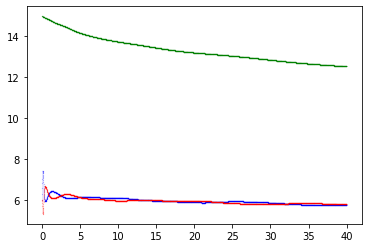

<Figure size 432x288 with 0 Axes>

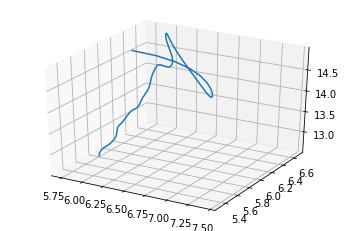

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654266_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654266_3D.png


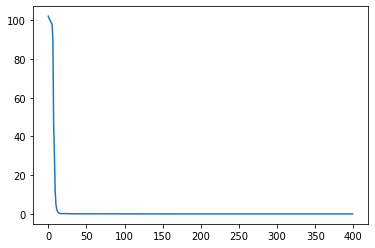

Epoch [00410/01000] Loss:0.012923 Loss_1:0.000547 Loss_2:0.012376 Loss_3:0.000000 Lr:0.000709 Time:11.578816s (9.48min in total)
Epoch [00420/01000] Loss:0.012925 Loss_1:0.000548 Loss_2:0.012377 Loss_3:0.000000 Lr:0.000704 Time:9.082807s (9.63min in total)
Epoch [00430/01000] Loss:0.012926 Loss_1:0.000548 Loss_2:0.012378 Loss_3:0.000000 Lr:0.000699 Time:10.818620s (9.82min in total)
Epoch [00440/01000] Loss:0.012928 Loss_1:0.000549 Loss_2:0.012379 Loss_3:0.000000 Lr:0.000694 Time:11.764550s (10.01min in total)
Epoch [00450/01000] Loss:0.012930 Loss_1:0.000549 Loss_2:0.012381 Loss_3:0.000000 Lr:0.000690 Time:9.779981s (10.17min in total)
Epoch [00460/01000] Loss:0.012933 Loss_1:0.000549 Loss_2:0.012383 Loss_3:0.000000 Lr:0.000685 Time:12.499338s (10.38min in total)
Epoch [00470/01000] Loss:0.012936 Loss_1:0.000550 Loss_2:0.012386 Loss_3:0.000000 Lr:0.000680 Time:10.940643s (10.56min in total)
Epoch [00480/01000] Loss:0.012938 Loss_1:0.000550 Loss_2:0.012388 Loss_3:0.000000 Lr:0.000676 T

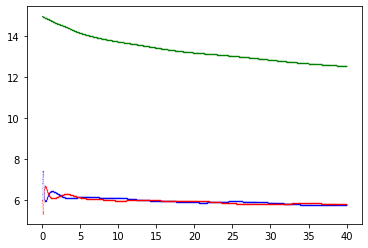

<Figure size 432x288 with 0 Axes>

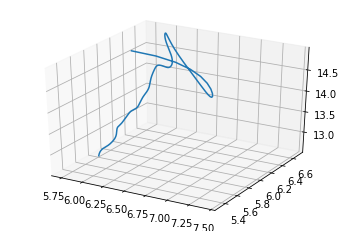

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654374_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654374_3D.png


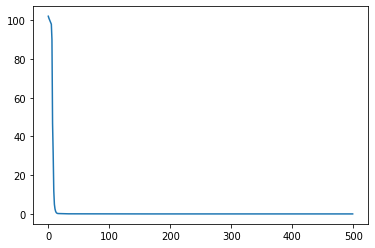

Epoch [00510/01000] Loss:0.012946 Loss_1:0.000551 Loss_2:0.012395 Loss_3:0.000000 Lr:0.000662 Time:13.693944s (11.33min in total)
Epoch [00520/01000] Loss:0.012941 Loss_1:0.000552 Loss_2:0.012389 Loss_3:0.000000 Lr:0.000658 Time:6.502232s (11.44min in total)
Epoch [00530/01000] Loss:0.012926 Loss_1:0.000562 Loss_2:0.012364 Loss_3:0.000000 Lr:0.000654 Time:14.108209s (11.67min in total)
Epoch [00540/01000] Loss:0.012929 Loss_1:0.000565 Loss_2:0.012364 Loss_3:0.000000 Lr:0.000649 Time:11.840336s (11.87min in total)
Epoch [00550/01000] Loss:0.012931 Loss_1:0.000568 Loss_2:0.012362 Loss_3:0.000000 Lr:0.000645 Time:8.981369s (12.02min in total)
Epoch [00560/01000] Loss:0.012932 Loss_1:0.000572 Loss_2:0.012360 Loss_3:0.000000 Lr:0.000641 Time:10.959869s (12.20min in total)
Epoch [00570/01000] Loss:0.012933 Loss_1:0.000574 Loss_2:0.012359 Loss_3:0.000000 Lr:0.000637 Time:9.153950s (12.35min in total)
Epoch [00580/01000] Loss:0.012935 Loss_1:0.000576 Loss_2:0.012359 Loss_3:0.000000 Lr:0.000633

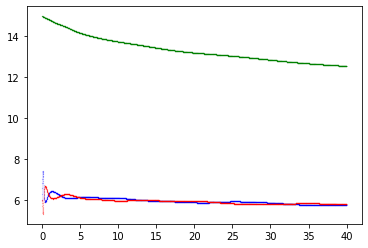

<Figure size 432x288 with 0 Axes>

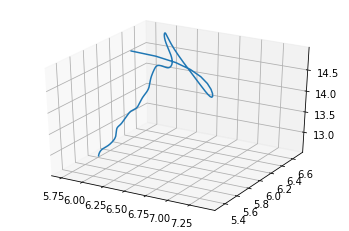

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654478_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654478_3D.png


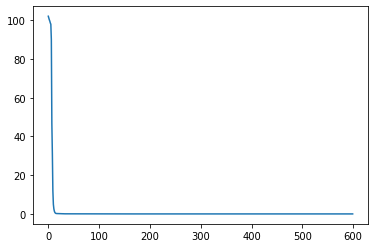

Epoch [00610/01000] Loss:0.012938 Loss_1:0.000582 Loss_2:0.012356 Loss_3:0.000000 Lr:0.000621 Time:11.296462s (13.01min in total)
Epoch [00620/01000] Loss:0.012938 Loss_1:0.000583 Loss_2:0.012355 Loss_3:0.000000 Lr:0.000617 Time:7.009681s (13.13min in total)
Epoch [00630/01000] Loss:0.012940 Loss_1:0.000585 Loss_2:0.012355 Loss_3:0.000000 Lr:0.000613 Time:8.853367s (13.28min in total)
Epoch [00640/01000] Loss:0.012941 Loss_1:0.000587 Loss_2:0.012354 Loss_3:0.000000 Lr:0.000610 Time:13.229884s (13.50min in total)
Epoch [00650/01000] Loss:0.012944 Loss_1:0.000589 Loss_2:0.012356 Loss_3:0.000000 Lr:0.000606 Time:11.949610s (13.69min in total)
Epoch [00660/01000] Loss:0.012945 Loss_1:0.000590 Loss_2:0.012355 Loss_3:0.000000 Lr:0.000602 Time:7.607605s (13.82min in total)
Epoch [00670/01000] Loss:0.012948 Loss_1:0.000591 Loss_2:0.012357 Loss_3:0.000000 Lr:0.000599 Time:8.334610s (13.96min in total)
Epoch [00680/01000] Loss:0.012952 Loss_1:0.000592 Loss_2:0.012360 Loss_3:0.000000 Lr:0.000595 

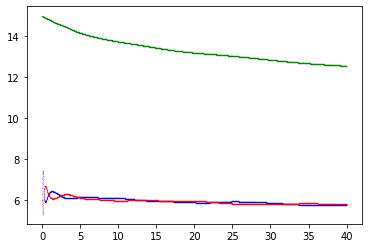

<Figure size 432x288 with 0 Axes>

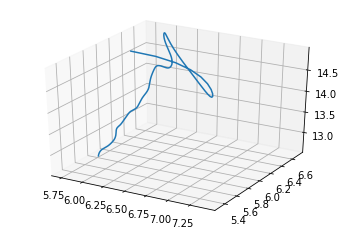

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654580_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654580_3D.png


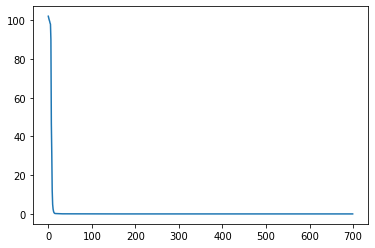

Epoch [00710/01000] Loss:0.012964 Loss_1:0.000594 Loss_2:0.012370 Loss_3:0.000000 Lr:0.000585 Time:9.738209s (14.69min in total)
Epoch [00720/01000] Loss:0.012967 Loss_1:0.000594 Loss_2:0.012373 Loss_3:0.000000 Lr:0.000581 Time:7.693309s (14.82min in total)
Epoch [00730/01000] Loss:0.012970 Loss_1:0.000595 Loss_2:0.012376 Loss_3:0.000000 Lr:0.000578 Time:5.448216s (14.91min in total)
Epoch [00740/01000] Loss:0.012975 Loss_1:0.000595 Loss_2:0.012380 Loss_3:0.000000 Lr:0.000575 Time:12.524186s (15.12min in total)
Epoch [00750/01000] Loss:0.012980 Loss_1:0.000595 Loss_2:0.012385 Loss_3:0.000000 Lr:0.000571 Time:11.010990s (15.30min in total)
Epoch [00760/01000] Loss:0.012987 Loss_1:0.000596 Loss_2:0.012391 Loss_3:0.000000 Lr:0.000568 Time:12.741064s (15.51min in total)
Epoch [00770/01000] Loss:0.012991 Loss_1:0.000596 Loss_2:0.012396 Loss_3:0.000000 Lr:0.000565 Time:9.458381s (15.67min in total)
Epoch [00780/01000] Loss:0.012999 Loss_1:0.000596 Loss_2:0.012403 Loss_3:0.000000 Lr:0.000562 

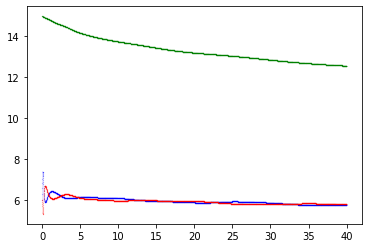

<Figure size 432x288 with 0 Axes>

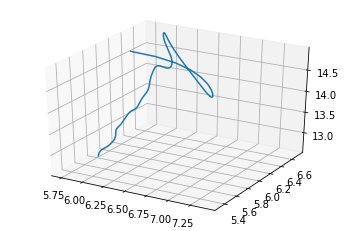

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654682_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654682_3D.png


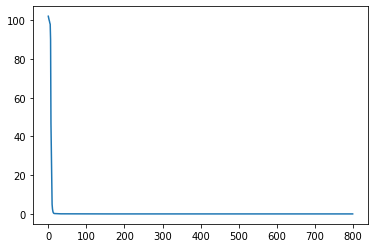

Epoch [00810/01000] Loss:0.012981 Loss_1:0.000602 Loss_2:0.012378 Loss_3:0.000000 Lr:0.000552 Time:14.910141s (16.47min in total)
Epoch [00820/01000] Loss:0.012961 Loss_1:0.000608 Loss_2:0.012353 Loss_3:0.000000 Lr:0.000549 Time:13.873411s (16.71min in total)
Epoch [00830/01000] Loss:0.012943 Loss_1:0.000614 Loss_2:0.012329 Loss_3:0.000000 Lr:0.000546 Time:13.044485s (16.92min in total)
Epoch [00840/01000] Loss:0.012933 Loss_1:0.000619 Loss_2:0.012314 Loss_3:0.000000 Lr:0.000543 Time:9.998227s (17.09min in total)
Epoch [00850/01000] Loss:0.012925 Loss_1:0.000624 Loss_2:0.012301 Loss_3:0.000000 Lr:0.000541 Time:10.206865s (17.26min in total)
Epoch [00860/01000] Loss:0.012920 Loss_1:0.000629 Loss_2:0.012291 Loss_3:0.000000 Lr:0.000538 Time:9.546364s (17.42min in total)
Epoch [00870/01000] Loss:0.012916 Loss_1:0.000634 Loss_2:0.012282 Loss_3:0.000000 Lr:0.000535 Time:13.060325s (17.64min in total)
Epoch [00880/01000] Loss:0.012913 Loss_1:0.000639 Loss_2:0.012274 Loss_3:0.000000 Lr:0.00053

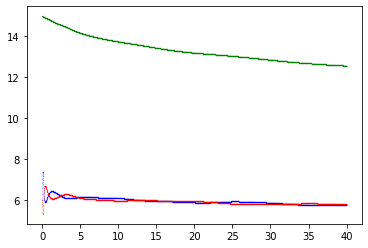

<Figure size 432x288 with 0 Axes>

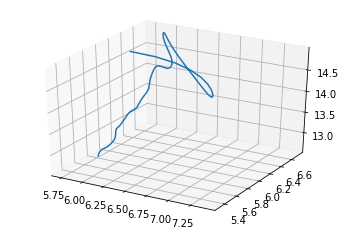

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654803_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654803_3D.png


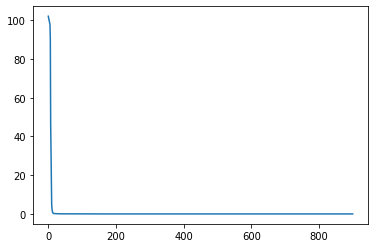

Epoch [00910/01000] Loss:0.012916 Loss_1:0.000655 Loss_2:0.012260 Loss_3:0.000000 Lr:0.000524 Time:13.281183s (18.46min in total)
Epoch [00920/01000] Loss:0.012918 Loss_1:0.000658 Loss_2:0.012259 Loss_3:0.000000 Lr:0.000521 Time:8.597724s (18.60min in total)
Epoch [00930/01000] Loss:0.012922 Loss_1:0.000664 Loss_2:0.012258 Loss_3:0.000000 Lr:0.000518 Time:13.050062s (18.82min in total)
Epoch [00940/01000] Loss:0.012926 Loss_1:0.000667 Loss_2:0.012259 Loss_3:0.000000 Lr:0.000515 Time:7.983114s (18.95min in total)
Epoch [00950/01000] Loss:0.012929 Loss_1:0.000670 Loss_2:0.012259 Loss_3:0.000000 Lr:0.000513 Time:9.746299s (19.11min in total)
Epoch [00960/01000] Loss:0.012935 Loss_1:0.000675 Loss_2:0.012261 Loss_3:0.000000 Lr:0.000510 Time:10.215096s (19.28min in total)
Epoch [00970/01000] Loss:0.012939 Loss_1:0.000677 Loss_2:0.012262 Loss_3:0.000000 Lr:0.000508 Time:6.498157s (19.39min in total)
Epoch [00980/01000] Loss:0.012947 Loss_1:0.000682 Loss_2:0.012265 Loss_3:0.000000 Lr:0.000505 

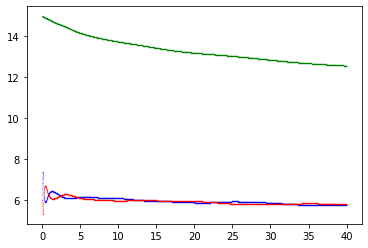

<Figure size 432x288 with 0 Axes>

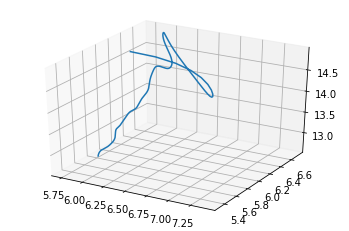

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654906_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkLorenz_1000_10_0.001_14.0_10.0_2.6666666666666665_2022-04-11-05-08-25_1649654906_3D.png


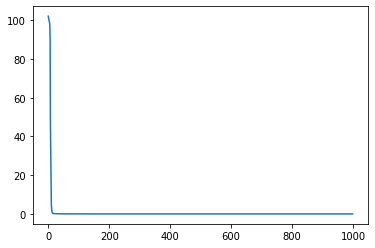

<Figure size 432x288 with 0 Axes>

In [ ]:
# Lorenz - Design D
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigLorenz
model = SimpleNetworkLorenz(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.rho}_{config.sigma}_{config.beta}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.rho}_{config.sigma}_{config.beta}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.rho}_{config.sigma}_{config.beta}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_lorenz(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

In [ ]:
# SIS - Design A
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigSIS
model = SimpleNetworkSIS(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_sis(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

In [ ]:
# loss
import numpy as np
loss_a = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_loss_200.npy")
loss_d = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_loss_200.npy")

start = 50
end = len(loss_a)
x = range(start + 1, end + 1)
plt.figure(dpi=300, figsize=[20,10])
plt.plot(x, loss_a[start:], marker='.', markersize=0.5, linewidth=0.3, c="b")
plt.plot(x, loss_d[start:], marker='.', markersize=0.5, linewidth=0.3, c="r")
plt.legend(["Design (A)","Design (D)"])
plt.show()
plt.clf()

0 [1. 1. 1.]
1 [1.01256574 1.25992001 0.98489104]
2 [1.04882146 1.52400084 0.97311434]
3 [1.1072063  1.79831458 0.9651591 ]
4 [1.18686548 2.08854554 0.96173738]
5 [1.2875548  2.4001604  0.96380622]
6 [1.4095688  2.7385521  0.97260828]
7 [1.55368879 3.109161   0.9897312 ]
8 [1.72114579 3.51757713 1.01718656]
9 [1.91359639 3.96962349 1.05751187]
10 [2.13310759 4.47142013 1.11389892]
11 [2.38214825 5.02942568 1.19035375]
12 [2.66358392 5.65045016 1.29189358]
13 [2.98067171 6.34162953 1.42478706]
14 [3.33705066 7.11034747 1.59684371]
15 [3.73672242 7.96408398 1.8177572 ]
16 [4.18401453 8.91016244 2.09950437]
17 [4.6835169  9.95535777 2.45679535]
18 [ 5.23997827 11.10531666  2.90755965]
19 [ 5.85814594 12.36372981  3.47343487]
20 [ 6.54252712 13.73118578  4.18019687]
21 [ 7.29704559 15.20363303  5.05802887]
22 [ 8.12456299 16.77038618  6.14146836]
23 [ 9.0262327  18.41165164  7.46879695]
24 [10.00065824 20.09563131  9.08055288]
25 [11.0428436  21.77541652 11.01677156]
26 [12.14295495 23.386

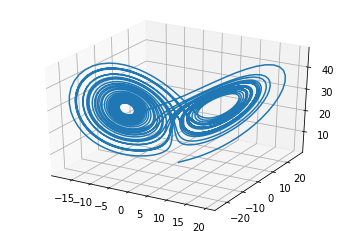

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)
for index, item in enumerate(states):
  print(index, item)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

In [ ]:
!pip install deepxde

     |████████████████████████████████| 121 kB 7.2 MB/s 
     |████████████████████████████████| 100 kB 11.6 MB/s 


In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def gen_traindata():
    data = np.load("../dataset/Lorenz.npz")
    return data["t"], data["y"]


C1 = dde.Variable(1.0)
C2 = dde.Variable(1.0)
C3 = dde.Variable(1.0)


def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (15 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]


def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.icbc.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 27, boundary, component=2)

# Get the train data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[C1, C2, C3])
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], period=600, filename="variables.dat"
)
losshistory, train_state = model.train(epochs=60000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)